# Determining Tennis Match Outcomes of ATP Players using Quantum Machine Learning
* Import all necessary libraries from qiskit

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

## We prepare a simple classification dataset to illustrate the following algorithms
* Data retrieved from https://www.kaggle.com/datasets/jordangoblet/atp-tour-20002016?resource=download
* A dataset is composed of rows of feature vectors and y-values
* A feature vector contains elements of real numbers in a range from [-1, 1]
* If the dataset with values not in range from [-1, 1], we must change it to [-1, 1]
* A y-value of -1 means a loss, and a y-value of +1 means a win

### Loading dataset
* Carpet - 0
* Hard - 1
* Clay - 2
* Grass - 3
The QML 
library requires numerical values for inputs. Some of the feature in the dataset is not numerical values. So we have to convert them into values like the above Surface data. We use Excel to pre-process the raw dataset . 

In [69]:
# There may be some encoding issues, so we specify a specific encoding. Otherwise, the dataset can not be loaded.
import pandas as pd

data = pd.read_csv("DataCleaned.csv", encoding = "ISO-8859-1", low_memory=False)


### Fill in NaN with the average of known values
* There are quite a few of missing data that have been translated to NaN (Not a number) in the system. 
* In order to process the dataset, we use the column average for the missing data.
* Although using the mean may not be the most accurate value, we must need some value in the box in order to normalize the entire dataset.

In [70]:
dataNoNaN = data.fillna(data.mean())
normalized = 2*(dataNoNaN-dataNoNaN.mean())/(dataNoNaN.max()-dataNoNaN.min())



In [86]:
# randomly select half of the total # of sample rows for positive samples
# Note that the heading B&WW cannot contain &. So I replace & with _ in the dataset using Excel.
# note that too many samples may be running forever
num_inputs = 10
# num_inputs is the columns
num_samples = 20
# num_samples is the rows
half_num_samples = num_samples//2
Xp = normalized.sample(n=half_num_samples)
Xp

#ALL POSITIVE

,Surface,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,...,W5,L5,Wsets,Lsets,B_WW,B_WL,MaxW,MaxL,AvgW,AvgL
11966,0.047758,0.013704,-0.008154,0.344952,0.559082,0.064898,-0.815320,0.000000,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
26329,-0.618909,-0.044527,0.026539,0.059238,-0.012346,0.350613,0.613251,0.000000,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
27479,1.381091,-0.026529,-0.024416,0.344952,0.273368,0.350613,0.613251,-0.576644,6.877871e-01,6.368738e-02,...,-5.075305e-17,-3.918434e-17,0.572123,0.594701,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
37493,-0.618909,-0.017000,-0.023874,-0.797905,0.559082,0.350613,0.613251,-0.005215,-1.693558e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,2.688726e-02,-3.923914e-04,9.090378e-02,-1.296360e-01
3394,-0.618909,-0.024411,-0.014388,0.059238,-0.869489,0.064898,-1.101035,0.000000,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
10689,-0.618909,0.013704,-0.011678,0.059238,-0.298060,0.064898,-0.529606,0.000000,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
38225,-0.618909,0.057114,0.012716,0.059238,-0.869489,-1.077959,0.613251,-0.005215,-7.407843e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,-8.584135e-03,-3.421390e-04,-1.961316e-02,-8.052509e-02
18430,-0.618909,-0.024411,0.035483,0.344952,0.559082,0.064898,0.041822,0.000000,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
13690,0.047758,-0.037116,-0.000023,0.059238,-0.012346,-0.792245,0.613251,-0.005215,-1.693558e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
44194,0.047758,-0.046645,-0.023603,0.059238,-0.012346,-1.649387,0.613251,0.280499,4.020728e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,4.022237e-02,-3.947397e-04,1.140767e-01,-1.318940e-01


In [87]:
# 
# for each positive sample, we derive a negative sample by sawpping winner's and loser's features
Xn = Xp.copy()
Xn.WRank, Xn.LRank = Xn.LRank, Xn.WRank
Xn.W1, Xn.L1 = Xn.L1, Xn.W1
Xn.W2, Xn.L2 = Xn.L2, Xn.W2
Xn.W3, Xn.L3 = Xn.L3, Xn.W3
Xn.W4, Xn.L4 = Xn.L4, Xn.W4
Xn.W5, Xn.L5 = Xn.L5, Xn.W5
Xn.Wsets, Xn.Lsets = Xn.Lsets, Xn.Wsets
Xn.B_WW, Xn.B_WL = Xn.B_WL, Xn.B_WW
Xn.MaxW, Xn.MaxL = Xn.MaxL, Xn.MaxW
Xn.AvgW, Xn.AvgL = Xn.AvgL, Xn.AvgW
Xn

# ALL NEGATIVE

,Surface,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,...,W5,L5,Wsets,Lsets,B_WW,B_WL,MaxW,MaxL,AvgW,AvgL
11966,0.047758,-0.008154,0.013704,0.559082,0.344952,-0.815320,0.064898,1.268826e-16,0.000000,0.000000,...,-3.918434e-17,-5.075305e-17,-0.405299,-0.094543,-1.113006e-16,1.368534e-16,-8.342643e-20,5.921979e-18,7.520562e-17,-1.979007e-17
26329,-0.618909,0.026539,-0.044527,-0.012346,0.059238,0.613251,0.350613,1.268826e-16,0.000000,0.000000,...,-3.918434e-17,-5.075305e-17,-0.405299,-0.094543,-1.113006e-16,1.368534e-16,-8.342643e-20,5.921979e-18,7.520562e-17,-1.979007e-17
27479,1.381091,-0.024416,-0.026529,0.273368,0.344952,0.613251,0.350613,6.877871e-01,-0.576644,-0.249003,...,-3.918434e-17,-5.075305e-17,0.594701,0.572123,-1.113006e-16,1.368534e-16,-8.342643e-20,5.921979e-18,7.520562e-17,-1.979007e-17
37493,-0.618909,-0.023874,-0.017000,0.559082,-0.797905,0.613251,0.350613,-1.693558e-01,-0.005215,0.000000,...,-3.918434e-17,-5.075305e-17,0.594701,-0.094543,-1.113006e-16,1.368534e-16,-3.923914e-04,2.688726e-02,-1.296360e-01,9.090378e-02
3394,-0.618909,-0.014388,-0.024411,-0.869489,0.059238,-1.101035,0.064898,1.268826e-16,0.000000,0.000000,...,-3.918434e-17,-5.075305e-17,-0.405299,-0.094543,-1.113006e-16,1.368534e-16,-8.342643e-20,5.921979e-18,7.520562e-17,-1.979007e-17
10689,-0.618909,-0.011678,0.013704,-0.298060,0.059238,-0.529606,0.064898,1.268826e-16,0.000000,0.000000,...,-3.918434e-17,-5.075305e-17,-0.405299,-0.094543,-1.113006e-16,1.368534e-16,-8.342643e-20,5.921979e-18,7.520562e-17,-1.979007e-17
38225,-0.618909,0.012716,0.057114,-0.869489,0.059238,0.613251,-1.077959,-7.407843e-01,-0.005215,0.000000,...,-3.918434e-17,-5.075305e-17,0.594701,-0.094543,-1.113006e-16,1.368534e-16,-3.421390e-04,-8.584135e-03,-8.052509e-02,-1.961316e-02
18430,-0.618909,0.035483,-0.024411,0.559082,0.344952,0.041822,0.064898,1.268826e-16,0.000000,0.000000,...,-3.918434e-17,-5.075305e-17,-0.405299,-0.094543,-1.113006e-16,1.368534e-16,-8.342643e-20,5.921979e-18,7.520562e-17,-1.979007e-17
13690,0.047758,-0.000023,-0.037116,-0.012346,0.059238,0.613251,-0.792245,-1.693558e-01,-0.005215,0.000000,...,-3.918434e-17,-5.075305e-17,0.594701,-0.094543,-1.113006e-16,1.368534e-16,-8.342643e-20,5.921979e-18,7.520562e-17,-1.979007e-17
44194,0.047758,-0.023603,-0.046645,-0.012346,0.059238,0.613251,-1.649387,4.020728e-01,0.280499,0.000000,...,-3.918434e-17,-5.075305e-17,0.594701,-0.094543,-1.113006e-16,1.368534e-16,-3.947397e-04,4.022237e-02,-1.318940e-01,1.140767e-01


In [88]:
# Now we have positive Xp and negative Xn samples
Xn = Xp.append(Xn)
Xn
# This datasheet includes positive and negative samples; we must have some negative samples because we can't have all positive

C:\Users\elo99\AppData\Local\Temp\ipykernel_15904\815995221.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Xn = Xp.append(Xn)


,Surface,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,...,W5,L5,Wsets,Lsets,B_WW,B_WL,MaxW,MaxL,AvgW,AvgL
11966,0.047758,0.013704,-0.008154,0.344952,0.559082,0.064898,-0.815320,0.000000e+00,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
26329,-0.618909,-0.044527,0.026539,0.059238,-0.012346,0.350613,0.613251,0.000000e+00,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
27479,1.381091,-0.026529,-0.024416,0.344952,0.273368,0.350613,0.613251,-5.766440e-01,6.877871e-01,6.368738e-02,...,-5.075305e-17,-3.918434e-17,0.572123,0.594701,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
37493,-0.618909,-0.017000,-0.023874,-0.797905,0.559082,0.350613,0.613251,-5.215473e-03,-1.693558e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,2.688726e-02,-3.923914e-04,9.090378e-02,-1.296360e-01
3394,-0.618909,-0.024411,-0.014388,0.059238,-0.869489,0.064898,-1.101035,0.000000e+00,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
10689,-0.618909,0.013704,-0.011678,0.059238,-0.298060,0.064898,-0.529606,0.000000e+00,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
38225,-0.618909,0.057114,0.012716,0.059238,-0.869489,-1.077959,0.613251,-5.215473e-03,-7.407843e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,-8.584135e-03,-3.421390e-04,-1.961316e-02,-8.052509e-02
18430,-0.618909,-0.024411,0.035483,0.344952,0.559082,0.064898,0.041822,0.000000e+00,1.268826e-16,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,-0.405299,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
13690,0.047758,-0.037116,-0.000023,0.059238,-0.012346,-0.792245,0.613251,-5.215473e-03,-1.693558e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,5.921979e-18,-8.342643e-20,-1.979007e-17,7.520562e-17
44194,0.047758,-0.046645,-0.023603,0.059238,-0.012346,-1.649387,0.613251,2.804988e-01,4.020728e-01,2.537653e-16,...,-5.075305e-17,-3.918434e-17,-0.094543,0.594701,1.368534e-16,-1.113006e-16,4.022237e-02,-3.947397e-04,1.140767e-01,-1.318940e-01


In [84]:
# QML library requires array of arrays. The dataset is in dataframe that cannot be processed directly.
# So we need to convert dataframe to numpy array
X = Xn.to_numpy()

# After the conversion, we also need to make sure the input dimension match the input dimension to the QNN.
# We have 21 features in each row and each feature needs a qubit. Simulating 21 qubits takes a long time.
# So the following slice out to fit # of qubits, which is # of inputs.
# The number of samples also affects simulation time drastically, so we should not set it too large (over 200).

X = X[0:num_samples, 0:num_inputs]

# display data in X for debugging
X

array([[ 4.77578668e-02, -3.39398409e-02, -9.78027754e-03,
         3.44952163e-01,  2.73368189e-01, -5.06530239e-01,
         6.13251031e-01,  2.80498813e-01,  4.02072816e-01,
         3.49401663e-01],
       [ 4.77578668e-02, -6.14676334e-02, -1.35748296e-02,
         3.44952163e-01,  2.73368189e-01,  6.48983322e-02,
        -5.29606112e-01, -5.21547257e-03,  1.16358530e-01,
         2.53765263e-16],
       [ 7.14424533e-01, -3.23576472e-03, -2.49584860e-02,
         5.92378778e-02,  8.44796760e-01,  6.48983322e-02,
        -2.43891826e-01, -5.21547257e-03, -1.69355755e-01,
         2.53765263e-16],
       [ 4.77578668e-02,  6.55837165e-02, -2.08928944e-02,
         3.44952163e-01,  5.59082475e-01,  6.48983322e-02,
        -5.29606112e-01,  0.00000000e+00,  1.26882631e-16,
         2.53765263e-16],
       [ 4.77578668e-02,  1.20639301e-01, -3.00429163e-03,
         5.92378778e-02, -2.98060383e-01, -7.92244525e-01,
         6.13251031e-01, -5.21547257e-03, -7.40784327e-01,
         2.

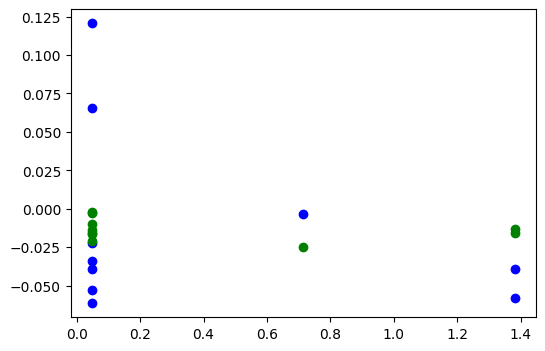

In [74]:
#X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
#y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y01 = np.full(shape=num_samples, fill_value=0)
for i in range(num_samples):
    if i<num_samples/2 :
        y01[i] = 1
    else:
        y01[i]=0
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
#plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

# The graph shows data from a two-dimensional persepctive, not taking account to the other 8 feature vectors.

## Building a quatum circuit to perform machine learning

In [75]:
y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

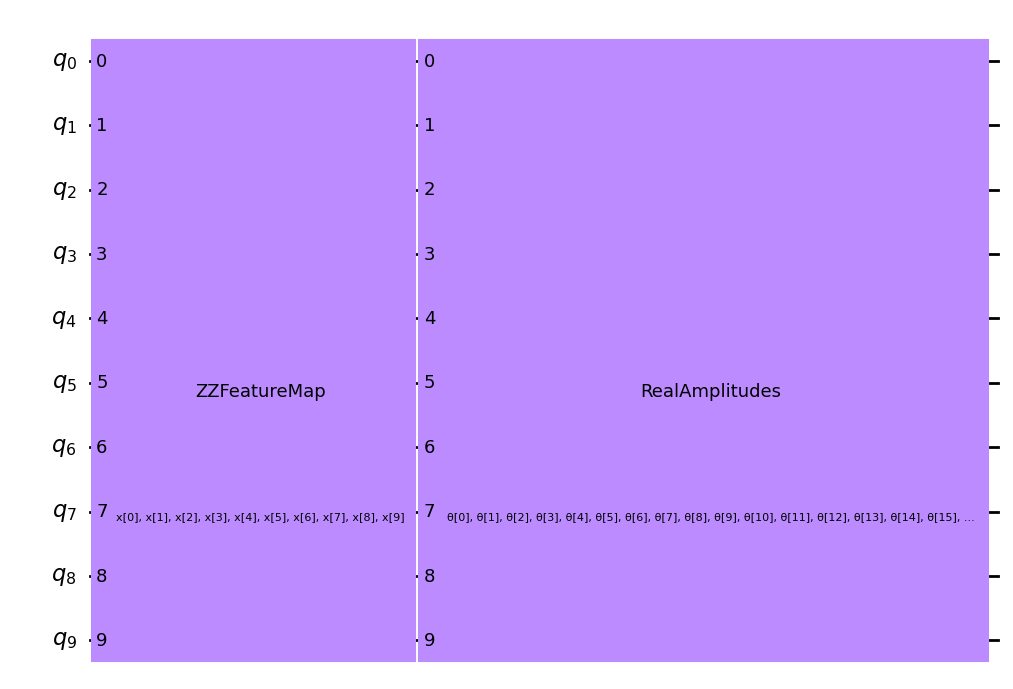

In [76]:
# construct QNN
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes

qc = QuantumCircuit(num_inputs)
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

# q_0...q_9 are the 10 qubits from (num_inputs) that represent the feature vectors
# ZZFeatureMap implements the 10 qubits/feature vectors
# RealAmplitudes is the all the values of the qubits/feature vectors
# (In the Excel datasheet, RealAmplitudes is all the values under the columns and rows)

## Create a quantum neural network

In [77]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, 0:num_inputs], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.03212212]])

## A callback function will be created to update information after the process loops

In [78]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [79]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

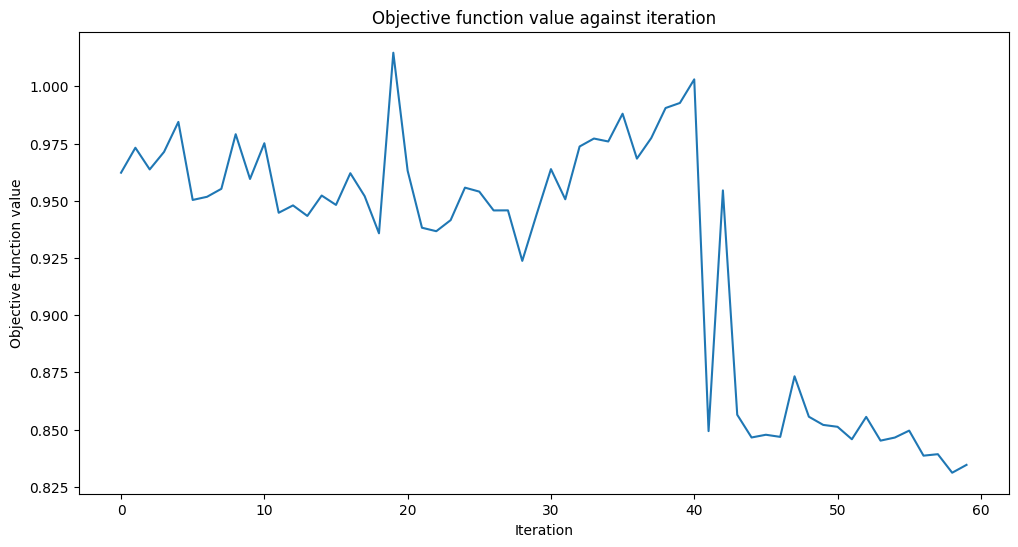

0.75

In [89]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

# Objective function value is the level of accuracy; the line in the graph will always be going down eventually because of machine learning.
# This graph shows 75% accuracy

## Data Visualization

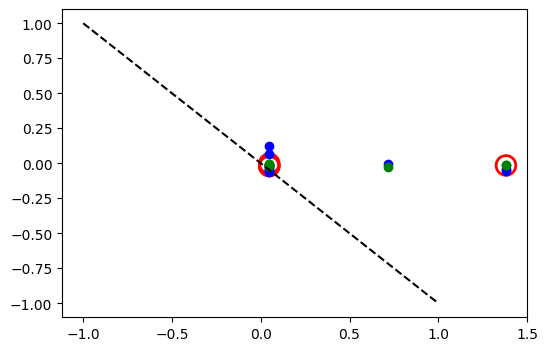

In [81]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

# This graph plots the first two feature vectors (num_inputs) out of 10 feature vectors. We cannot visually see dimensions greater than 3, but this
# graph takes information from 10 feature vectors and converts it to a graph with 2 feature vectors.
# Over the reference line (dotted line) is win, and below the line is loss. 
# Red circles represent miscalculations.

## The weights between neurons

* Weights are coefficients among neurons in the neuron network after the AI has finished learning all the data.

In [82]:
estimator_classifier.weights

array([ 0.8355267 ,  0.8261186 ,  0.64556914,  1.07211734,  1.91313776,
        0.31171088,  0.4863456 ,  0.07873152,  0.63226388,  0.02045437,
        0.98508885, -0.4470769 ,  1.7954946 ,  1.04909625,  1.16232367,
        1.56771126,  1.27891545,  1.61593357, -0.44888614, -0.05531706,
        0.65324453,  0.46536299,  0.52947439,  0.6410244 ,  0.52150782,
        0.49147158,  0.49690463,  1.3787538 , -0.09542032,  0.18766382,
        0.0473653 ,  0.09807697,  0.52134838, -0.09013177, -0.34114961,
        0.0038568 , -0.03982449,  0.24698349,  0.12839207,  0.29120308])